# Demo Feeder Concept
This notebook shows a basics of a feeder concept. This scenario has two vessels:
* a *vessel* for the transport of material
* an *installer*, receiving the material and installing it.
Thus, we also need two processes - one for each vessel. In this process the hand over of the material is done from the *vessel* to the *installer*.

In [1]:
import datetime
import time
import uuid

import numpy as np
# package(s) for data handling
import pandas as pd
import shapely.geometry
import simpy

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasMultiContainer,
        core.HasResource,
    ),
    {},
)

TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.MultiContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {"key": "MultiStoreHopper"},
)

## Definition of Sites

In [3]:
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

from_site = Site(
    env=my_env,
    name="Winlocatie",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    store_capacity=4,
    initials=[
        {"id": "MP", "level": 5, "capacity": 10},
        {"id": "TP", "level": 5, "capacity": 10},
    ],
)
to_site = Site(
    env=my_env,
    name="Dumplocatie",
    ID=str(uuid.uuid4()),
    geometry=location_to_site,
    store_capacity=4,
    initials=[
        {"id": "MP", "level": 0, "capacity": 5},
        {"id": "TP", "level": 0, "capacity": 5},
    ],
)

## Definition of Vessels

In [4]:
vessel = TransportProcessingResource(
    env=my_env,
    name="Vessel 01",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    loading_rate=1,
    unloading_rate=1,
    store_capacity=4,
    compute_v=lambda x: 10,
    initials=[
        {"id": "MP", "level": 0, "capacity": 2},
        {"id": "TP", "level": 0, "capacity": 2},
    ],
)

installer = TransportProcessingResource(
    env=my_env,
    name="Installer",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    loading_rate=1,
    unloading_rate=1,
    store_capacity=4,
    compute_v=lambda x: 10,
    initials=[
        {"id": "MP", "level": 0, "capacity": 1},
        {"id": "TP", "level": 0, "capacity": 1},
    ],
)

## Definition of Vessel process

## Definition of Installer process

In [5]:
vessel_proc = model.WhileActivity(
    env=my_env,
    name="single run while",
    ID=str(uuid.uuid4()),
    registry=registry,
    sub_processes=[
        model.SequentialActivity(
            env=my_env,
            name="Single run process",
            ID=str(uuid.uuid4()),
            registry=registry,
            sub_processes=[
                model.MoveActivity(
                    env=my_env,
                    name="sailing empty",
                    ID=str(uuid.uuid4()),
                    registry=registry,
                    mover=vessel,
                    destination=from_site,
                ),
                model.ShiftAmountActivity(
                    env=my_env,
                    name="Load MP",
                    ID=str(uuid.uuid4()),
                    registry=registry,
                    processor=vessel,
                    origin=from_site,
                    destination=vessel,
                    amount=1,
                    duration=120,
                    id_="MP",
                ),
                model.MoveActivity(
                    env=my_env,
                    name="sailing filled",
                    ID=str(uuid.uuid4()),
                    registry=registry,
                    mover=vessel,
                    destination=to_site,
                ),
                model.ShiftAmountActivity(
                    env=my_env,
                    name="Transfer MP",
                    ID=str(uuid.uuid4()),
                    registry=registry,
                    processor=installer,
                    origin=vessel,
                    destination=installer,
                    amount=1,
                    duration=120,
                    id_="MP",
                    start_event=[
                        {
                            "type": "activity",
                            "name": "Sail transit",
                            "state": "done",
                        }
                    ],
                ),
            ],
        )
    ],
    condition_event=[
        {"type": "container", "concept": from_site, "state": "empty", "id_": "MP"}
    ],
)


installer_run2 = [
    model.BasicActivity(
        env=my_env,
        name="Sail transit",
        registry=registry,
        ID=str(uuid.uuid4()),
        duration=30,
        additional_logs=[installer],
    ),
    model.BasicActivity(
        env=my_env,
        name="Prepare installation",
        registry=registry,
        ID=str(uuid.uuid4()),
        duration=60,
        additional_logs=[installer],
        start_event=[
            {"type": "activity", "name": "Single run process", "state": "done"}
        ],
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="Install MP",
        ID=str(uuid.uuid4()),
        registry=registry,
        processor=installer,
        origin=installer,
        destination=to_site,
        amount=1,
        duration=120,
        id_="MP",
    ),
]
activity = model.SequentialActivity(
    env=my_env,
    name="Installer run process 2",
    ID=str(uuid.uuid4()),
    registry=registry,
    sub_processes=installer_run2,
)


installer_run = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        ID=str(uuid.uuid4()),
        registry=registry,
        mover=installer,
        destination=to_site,
    ),
    model.WhileActivity(
        env=my_env,
        name="installer run while",
        ID=str(uuid.uuid4()),
        registry=registry,
        sub_processes=[activity],
        condition_event=[
            {"type": "container", "concept": to_site, "state": "full", "id_": "MP"}
        ],
    ),
]

installer_proc = model.SequentialActivity(
    env=my_env,
    name="Installer run process",
    ID=str(uuid.uuid4()),
    registry=registry,
    sub_processes=installer_run,
)

In [6]:
model.register_processes([installer_proc, vessel_proc])
my_env.run()

In [7]:
plot.vessel_planning([*model.get_subprocesses(installer_proc), *model.get_subprocesses(vessel_proc)])

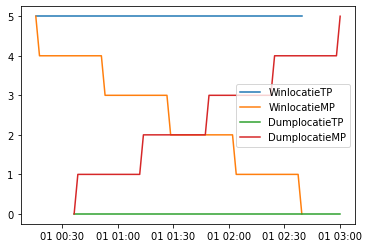

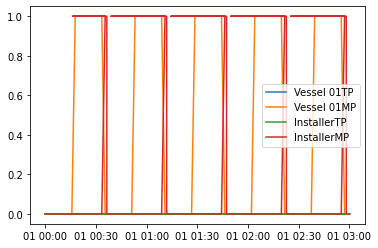

In [8]:
fig = plot.get_step_chart([from_site, to_site])
fig = plot.get_step_chart([vessel, installer])